# Generating Realistic Negative Financial Returns

This notebooks contains the implementative details of the project. 

**Summary:** This work aims at studying generative models that are capable of reproducing realistic data of negative log-returns of financial investments. The data used for training contains 746 four-dimensional observations. Each row refers to a simultaneous adverse loss of 4 different financial assets, but they are not in chronological order. The goal is to be able to replicate the magnitude of the losses, not to predict the time of their occurence. For an easier visualization, we changed the sign of the data to positive values. 
This is an unsupervised learning problem, and the criteria for evaluating a good performance are nontrivial. We will use the Anderson Darling distance (or AD distance) as a measure of accuracy of the tail estimation of the models and the Absolute Kendall Error (or AKE) to measure the correlation structure of the four features.
We propose two models: a Wasserstein-GAN, which has been succesfully employed in different tasks, and a simple but effective model based on an empirical Energy Distance between distributions.


See *Generative_Models.pdf* for details on the theory behind the models implemented and the explanation of the two metrics used to evaluate the model.

**Remark:** We will only use the Gaussian distribution as latent space distribution. We attempted at using some more heavy-tailed ditribution (exponential, t-Student, ...) but none of them performed better (despite some articles form the literature of estimating extreme values suggesting otherwise).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from w_gan import WGAN
from edm import EDM
from data_utils import *
from grid_searches import *
from visuals import *

seed = 42
np.random.seed(seed)

### Loading the Data

We split the data into training and testing data. To ensure a fair testing, we split proportionally the observations where at least one of the tickers is above the 90% quantile of that marginal distribution.

In [2]:
data_path = "data/data_log_return.csv"
training_path = 'data/val/train_data.csv'
validation_path = 'data/val/val_data.csv'
testing_path = 'data/test_data.csv'
training_and_val_path = 'data/train_data.csv'

load_data_balanced(
    data_path, training_and_val_path, testing_path
)

We further split training data into training and validation data.

In [3]:
load_data_balanced(
    training_and_val_path, training_path, validation_path
)

### A quick EDA

In order to have a feel of what the data looks like, let us plot have a look at summary statistics and plot some histograms of the marginals.

In [4]:
data = pd.read_csv(data_path, names=["idx", "X1", "X2", "X3", "X4"], header=0)
data = data.set_index(["idx"])
data.describe()

,X1,X2,X3,X4
count,745.000000,745.000000,745.000000,745.000000
mean,0.013145,0.012824,0.009374,0.010794
std,0.011922,0.011720,0.009287,0.009343
min,0.000012,0.000057,0.000014,0.000067
25%,0.004759,0.003876,0.003196,0.004219
50%,0.010025,0.009421,0.006642,0.008522
75%,0.017825,0.017813,0.012364,0.014229
max,0.098709,0.088502,0.072016,0.074291


Correlations are quite high, as expected. Replicating the correct correlation structure will be crucial.

In [5]:
corr = data.corr()
corr

,X1,X2,X3,X4
X1,1.000000,0.491825,0.434015,0.659544
X2,0.491825,1.000000,0.653692,0.450167
X3,0.434015,0.653692,1.000000,0.475379
X4,0.659544,0.450167,0.475379,1.000000


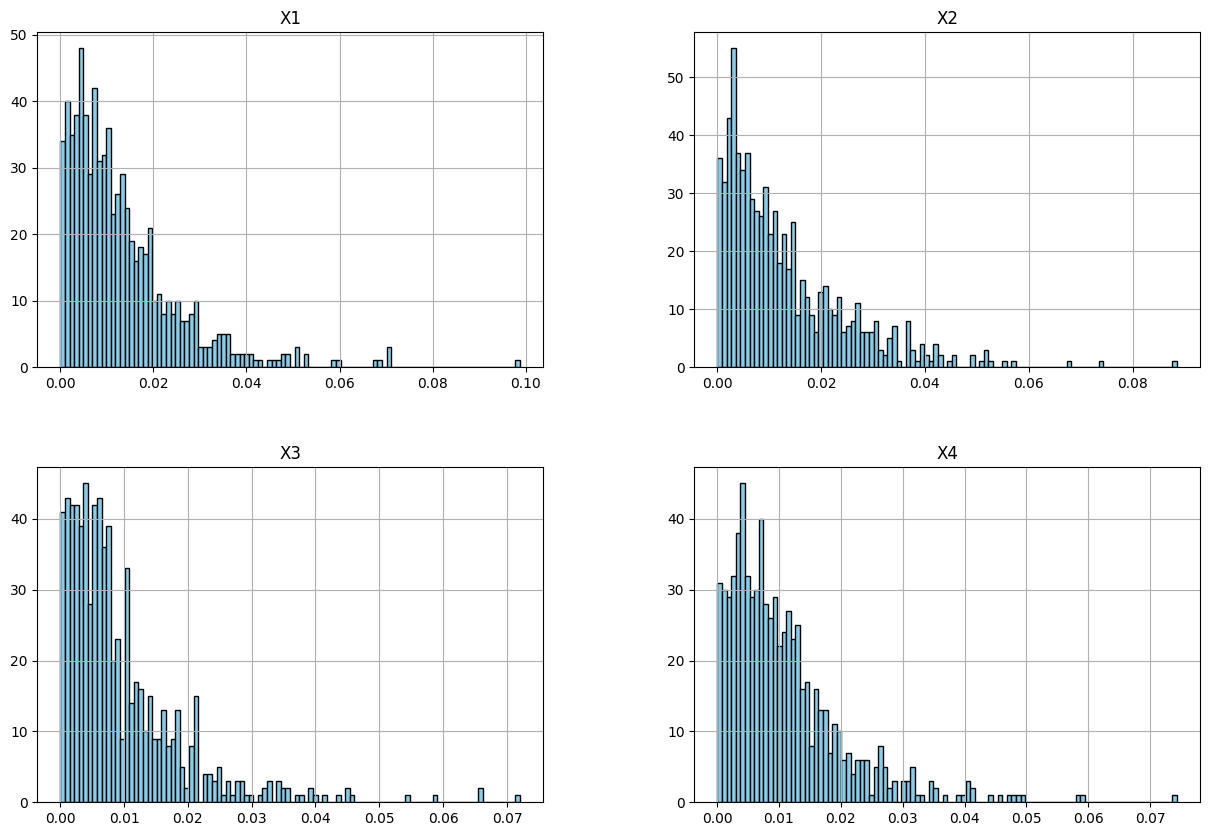

In [6]:
data.hist(bins=100, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.show()

### Wasserstein GAN
W-GAN is a more robust version of the standard GAN, with a critic estimating a probability of true/fake sample instead of a discriminator performing binary classification.
As a result, it's less prone to mode-collapse and does not add complexity in the implementation.

We attempted at some forms of early stopping. At first, we tried criteria based on the two metrics we will use to test the model: we run batches for an epoch, and generate data with the model at the end of the epoch. We compare it with the validation set, computing AD distance and AKE between the validation set and the generated data. If for a set number of epochs we do not observe an improvement in either metric/both metrics, we stop the training. It was not possible to define a single objective metric from the two, seeing as their scales are completely different and show an unclear dependence on the generated sample size.
This approach was unsuccesful, since we observed little regularity in AD distance and AKE during training and a tendency of these quantities to spike for a considerable number of epochs before improving.
We also provide an early stopping technique that relies on the energy distance between the generated data and the validation data. It doesn't seem to be too reliable either.

We opted for a classic grid search approach using the number of epochs as a hyperparameter to tune. At the end of training, the quality of a model is verified by generating data and computing AD distance and AKE with the validation data.

A more sound approach would be using cross validation. We provide an implementation, but WGAN is relatively costly from a computational point of view (for my machine), so we perform a grid search only. We still provide an example of usage of the cross validation method provided by the class WGAN. In the CV we implemented, the summary metrics used to evaluate the best set of parameters are the across-fold average of (very) late-start averages of AD distance and AKE computed in the last few epochs between generated data and the validation fold. The goal of the late-starting is to reduce a the variance of the metric, making it more reliable.

Here we show a small example of the lack of regularity of AD distance and AKE.

In [7]:
# set to true to perform the grid searches and CV steps.
run_next_cell = True

device cpu
Loading WGAN...
WGAN loaded.


100%|██████████| 2000/2000 [02:34<00:00, 12.93it/s]


Training done


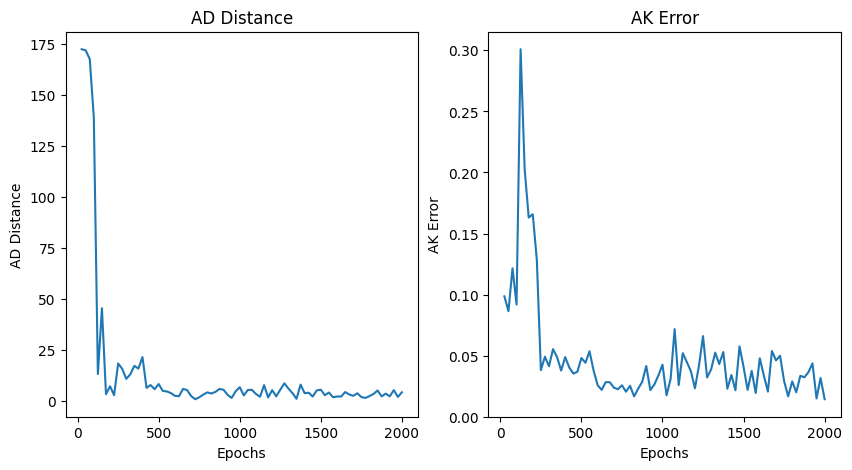

In [8]:
if run_next_cell:
    wgan = WGAN(16, 64, 64, 0.0001)
    ads, akes, epochs = wgan.train_with_history(training_path, epochs=2000, val_path = validation_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, ads)
    plt.title("AD Distance")
    plt.xlabel("Epochs")
    plt.ylabel("AD Distance")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, akes)
    plt.title("AK Error")
    plt.xlabel("Epochs")
    plt.ylabel("AK Error")
    plt.show()



Below the grid search implementation and the CV for the most promising models. Choices of epochs, network structures and range are partially led by some preliminary runs and qualitative assessments using Tensorboard and plotting the metrics of interest and some other more qualitative plots (like that of empirical CDFs, discussed in the last section) and some previous grid searches.
We actually considered latent dimensions from 4 to 64, networks form 16 to 256, other learning rates, ...

In [9]:
run_next_cell = True

In [10]:
par_dict = {
    "latent_dim" : [16, 32],
    "g_hidden_dim" : [64, 128, 256],
    "lr" : [0.0001], 
    "d_hidden_dim": [64, 128, 256]
}

if run_next_cell:
    grid_search_wgan(training_path, validation_path, par_dict, epochs=5000, every=500, path="results/grid_wgan.csv")

device cpu
Loading WGAN...
WGAN loaded.
WGAN, parameters: {'latent_dim': 16, 'g_hidden_dim': 64, 'lr': 0.0001, 'd_hidden_dim': 64}


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [07:02<00:00, 11.85it/s]
c:\Users\feder\OneDrive\Immagini\Documenti\GitHub\Generative-modelling-for-financial-data\grid_searches.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], axis=0)


Training done
device cpu
Loading WGAN...
WGAN loaded.
WGAN, parameters: {'latent_dim': 16, 'g_hidden_dim': 64, 'lr': 0.0001, 'd_hidden_dim': 128}


 11%|█         | 561/5000 [01:40<13:12,  5.60it/s]  


KeyboardInterrupt: 

Let's look at the best combinations. Priority should go to AD distance to ensure a good estimation of the tails.

In [ ]:
grid_results = pd.read_csv("results/grid_wgan.csv")
grid_results.sort_values(by=["AKE", "AD"], ascending=True)
grid_results["idx_ake_sorting"] = range(1, len(grid_results) + 1)
grid_results.sort_values(by=["AD", "AKE"], ascending=True)
grid_results.drop("Unnamed: 0", axis=1, inplace=True)
grid_results.head(8)

,latent_dim,g_hidden_dim,lr,d_hidden_dim,AD,AKE,epochs,idx_ake_sorting
0,16,64,0.0001,64,23.154472,0.025420,500,1
1,16,64,0.0001,64,7.150664,0.020728,1000,2


In [ ]:
best_params_wgan = {    
    "latent_dim" : 32,
    "g_hidden_dim" : 128,
    "lr" : 0.0001, 
    "d_hidden_dim": 128
}
best_wgan_epochs = 1000

To illustrate CV:

In [ ]:
run_next_cell = True

In [ ]:
if run_next_cell:
    wgan = WGAN(**best_params_wgan)
    ad_avg, ake_avg = wgan.cross_val(training_and_val_path, epochs = 100)
    print("AD: ", np.mean(ad_avg), " AKE: ", np.mean(ake_avg))

c:\Users\feder\OneDrive\Immagini\Documenti\GitHub\Generative-modelling-for-financial-data\w_gan.py:449: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.means = torch.tensor(
c:\Users\feder\OneDrive\Immagini\Documenti\GitHub\Generative-modelling-for-financial-data\w_gan.py:452: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stds = torch.tensor(
c:\Users\feder\OneDrive\Immagini\Documenti\GitHub\Generative-modelling-for-financial-data\w_gan.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_normalized)


device cpu
Loading WGAN...
WGAN loaded.
Fold:  1


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.31it/s]


Fold:  2


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


Fold:  3


100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


Fold:  4


100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


Fold:  5


100%|██████████| 100/100 [00:10<00:00,  9.85it/s]

AD:  [308.49489409549216, 58.368651167887535, 44.56324344679323, 19.962297503115387, 26.374345932160885]  AKE:  [0.051004130465745624, 0.22800170915823953, 0.09356217063096425, 0.06997578692493948, 0.07752456914969377]


### Energy Distance Model

This model is simpler and more unusual. However, it appears to be quite accurate and has considerable advantages in terms of computational costs.
Since the loss is simply the energy distance between generated data and real data, we can naturally add an early stopping criterion using the eergy distance between generated data and validation data at the end of each epoch. Similarly to WGAN, it was unsuccesful to apply a early stopping criterion based on AD distance and AKE.

We perform a grid search for hyperparameter tuning.

In [ ]:
par_dict = {
    "latent_dim" : [8, 16, 32],
    "g_hidden_dim" : [64, 128, 256],
    "lr" : [0.0001], 
}

grid_search_edm(training_path, validation_path, par_dict, epochs=5000, path="results/grid_edm.csv", patience=250)

device cpu
Loading EDM...
Model loaded.
EDM, number: 1, parameters: {'latent_dim': 8, 'g_hidden_dim': 64, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


c:\Users\feder\OneDrive\Immagini\Documenti\GitHub\Generative-modelling-for-financial-data\grid_searches.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row])


Early stopping at epoch 358.
Training done
Best loss: 0.0001605600118637085, Best epoch: 258, AD distance: 1.4846056063138775, AKE error: 0.01750700280112045
device cpu
Loading EDM...
Model loaded.
EDM, number: 2, parameters: {'latent_dim': 8, 'g_hidden_dim': 128, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 251.
Training done
Best loss: 0.00015131011605262756, Best epoch: 151, AD distance: 1.8263106676723488, AKE error: 0.011484593837535017
device cpu
Loading EDM...
Model loaded.
EDM, number: 3, parameters: {'latent_dim': 8, 'g_hidden_dim': 256, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 310.
Training done
Best loss: 0.00013896077871322632, Best epoch: 210, AD distance: 1.5641645393681074, AKE error: 0.02163865546218487
device cpu
Loading EDM...
Model loaded.
EDM, number: 4, parameters: {'latent_dim': 16, 'g_hidden_dim': 64, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 296.
Training done
Best loss: 0.00016452185809612274, Best epoch: 196, AD distance: 1.49843762963539, AKE error: 0.0273109243697479
device cpu
Loading EDM...
Model loaded.
EDM, number: 5, parameters: {'latent_dim': 16, 'g_hidden_dim': 128, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 204.
Training done
Best loss: 0.00016347691416740417, Best epoch: 104, AD distance: 1.3814715835322424, AKE error: 0.02535014005602241
device cpu
Loading EDM...
Model loaded.
EDM, number: 6, parameters: {'latent_dim': 16, 'g_hidden_dim': 256, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 221.
Training done
Best loss: 0.00016312673687934875, Best epoch: 121, AD distance: 1.5125205710874283, AKE error: 0.021498599439775914
device cpu
Loading EDM...
Model loaded.
EDM, number: 7, parameters: {'latent_dim': 32, 'g_hidden_dim': 64, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 309.
Training done
Best loss: 0.00015096180140972137, Best epoch: 209, AD distance: 1.238116709595399, AKE error: 0.029411764705882353
device cpu
Loading EDM...
Model loaded.
EDM, number: 8, parameters: {'latent_dim': 32, 'g_hidden_dim': 128, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 279.
Training done
Best loss: 0.00015189684927463531, Best epoch: 179, AD distance: 1.422318986498766, AKE error: 0.020098039215686272
device cpu
Loading EDM...
Model loaded.
EDM, number: 9, parameters: {'latent_dim': 32, 'g_hidden_dim': 256, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 186.
Training done
Best loss: 0.00016807392239570618, Best epoch: 86, AD distance: 1.4222682254919192, AKE error: 0.020868347338935573


,latent_dim,g_hidden_dim,lr,AD,AKE,epochs
0,8,64,0.0001,1.484606,0.017507,258
1,8,128,0.0001,1.826311,0.011485,151
2,8,256,0.0001,1.564165,0.021639,210
3,16,64,0.0001,1.498438,0.027311,196
4,16,128,0.0001,1.381472,0.025350,104
5,16,256,0.0001,1.512521,0.021499,121
6,32,64,0.0001,1.238117,0.029412,209
7,32,128,0.0001,1.422319,0.020098,179
8,32,256,0.0001,1.422268,0.020868,86


In [ ]:
grid_results = pd.read_csv("results/grid_edm.csv")
grid_results = grid_results.sort_values(by=["AKE", "AD"], ascending=True)
grid_results["idx_ake_sorting"] = range(1, len(grid_results) + 1)
grid_results = grid_results.sort_values(by=["AD", "AKE"], ascending=True)
grid_results["idx_ad_sorting"] = range(1, len(grid_results) + 1)
grid_results.drop("Unnamed: 0", axis=1, inplace=True)
grid_results.head(8)

,latent_dim,g_hidden_dim,lr,AD,AKE,epochs,idx_ake_sorting,idx_ad_sorting
6,32,64,0.0001,1.238117,0.029412,209,9,1
4,16,128,0.0001,1.381472,0.025350,104,7,2
8,32,256,0.0001,1.422268,0.020868,86,4,3
7,32,128,0.0001,1.422319,0.020098,179,3,4
0,8,64,0.0001,1.484606,0.017507,258,2,5
3,16,64,0.0001,1.498438,0.027311,196,8,6
5,16,256,0.0001,1.512521,0.021499,121,5,7
2,8,256,0.0001,1.564165,0.021639,210,6,8


In [ ]:
best_params_edm = {
    "latent_dim" : 32,
    "g_hidden_dim" : 64,
    "lr" : 0.0001
}
best_edm_epochs = 209

### Final training and testing

In [ ]:
edm = EDM(**best_params_edm)
wgan = WGAN(**best_params_wgan)

edm.train(training_and_val_path, epochs=best_edm_epochs)
wgan.train(training_and_val_path, epochs=best_wgan_epochs, checkpoints=False)

device cpu
Loading EDM...
Model loaded.
device cpu
Loading WGAN...
WGAN loaded.
[[0.06712907 0.08850208 0.0655656  0.07429127]
 [0.012357   0.02064872 0.03600894 0.00884954]
 [0.03003572 0.03935871 0.0275575  0.02336437]
 ...
 [0.00264142 0.00618169 0.00720537 0.00155474]
 [0.01663889 0.01185453 0.0039987  0.00562492]
 [0.00140803 0.02286409 0.00432845 0.00406734]]


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Training done


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]

Training done


We save the models.

In [ ]:
edm.save_model()
wgan.save_model()

In [ ]:
edm.load_model()
wgan.load_model()

In [ ]:
test_data = pd.read_csv(testing_path, names=["idx", "X1", "X2", "X3", "X4"], header=0)
test_data = test_data.set_index(["idx"])
test_data = test_data.values

edm_ad, edm_ake = edm.evaluate(test_data)
wgan_ad, wgan_ake = wgan.evaluate(test_data)

print("EDM AD: ", edm_ad, " AKE: ", edm_ake)
print("WGAN AD: ", wgan_ad, " AKE: ", wgan_ake)

EDM AD:  1.773452983533737  AKE:  0.019686800894854587
WGAN AD:  6.422385567774235  AKE:  0.05999999999999999


To assess them qualitatively, we can compare the empirical CDFS and the extreme values.

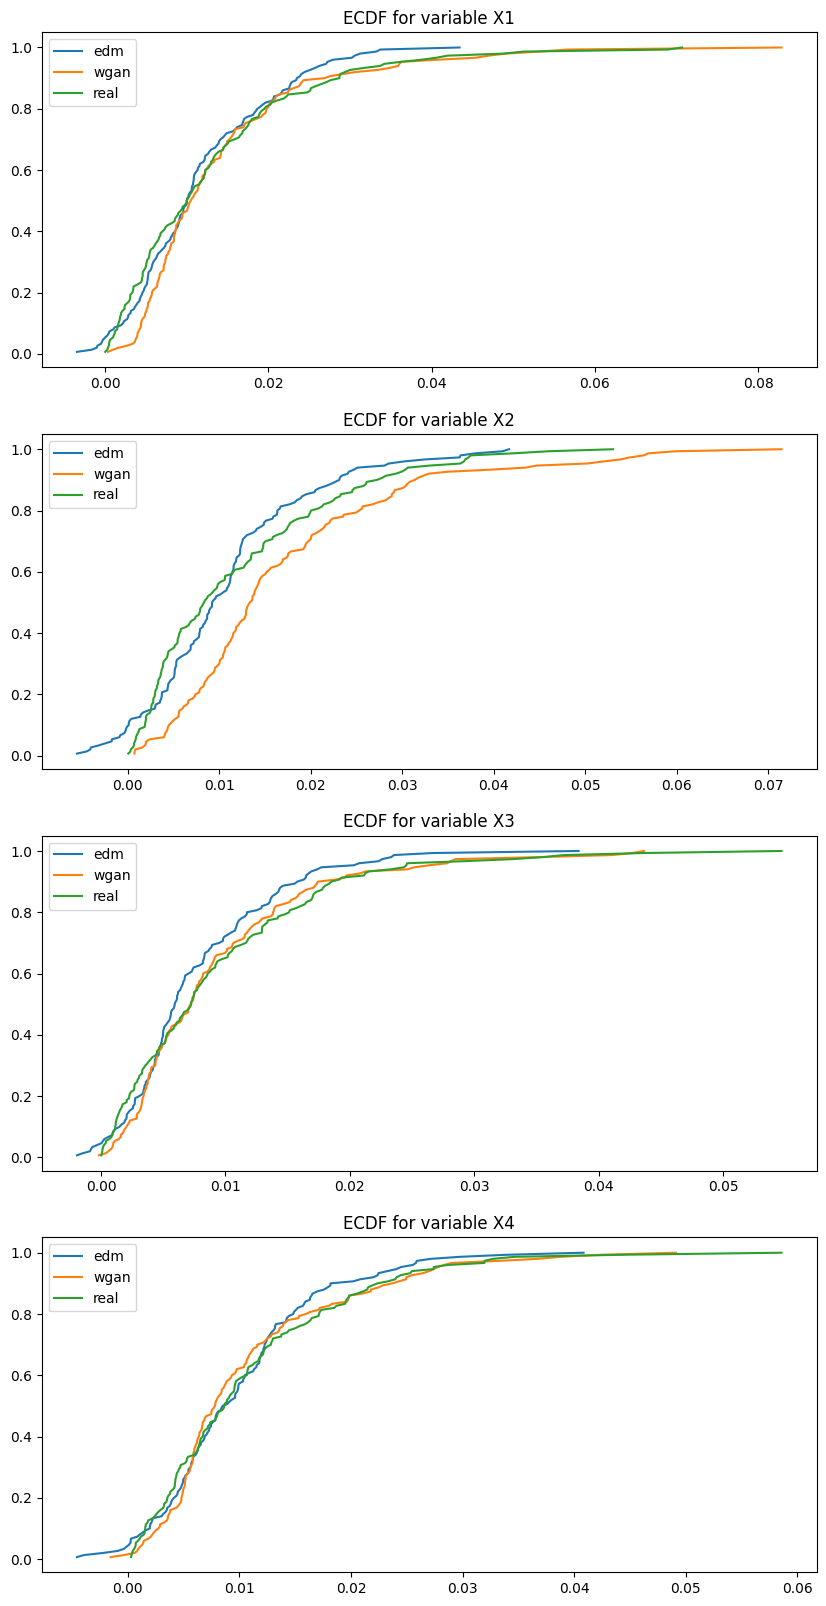

In [ ]:
data_edm = edm.generate(test_data.shape[0])
data_wgan = wgan.generate(test_data.shape[0])

plot_ecdfs(data_edm, data_wgan, test_data)

We observe a good resemblance of the empirical CDF of the marginals. Other models we attempted, like standard GAN and VAE, tended to display a completely inaccurate empirical CDF for at least one of the marginals.

Now we plot the bidimensional scatterplots and the densities of each feature for the energy model and for W-GAN.

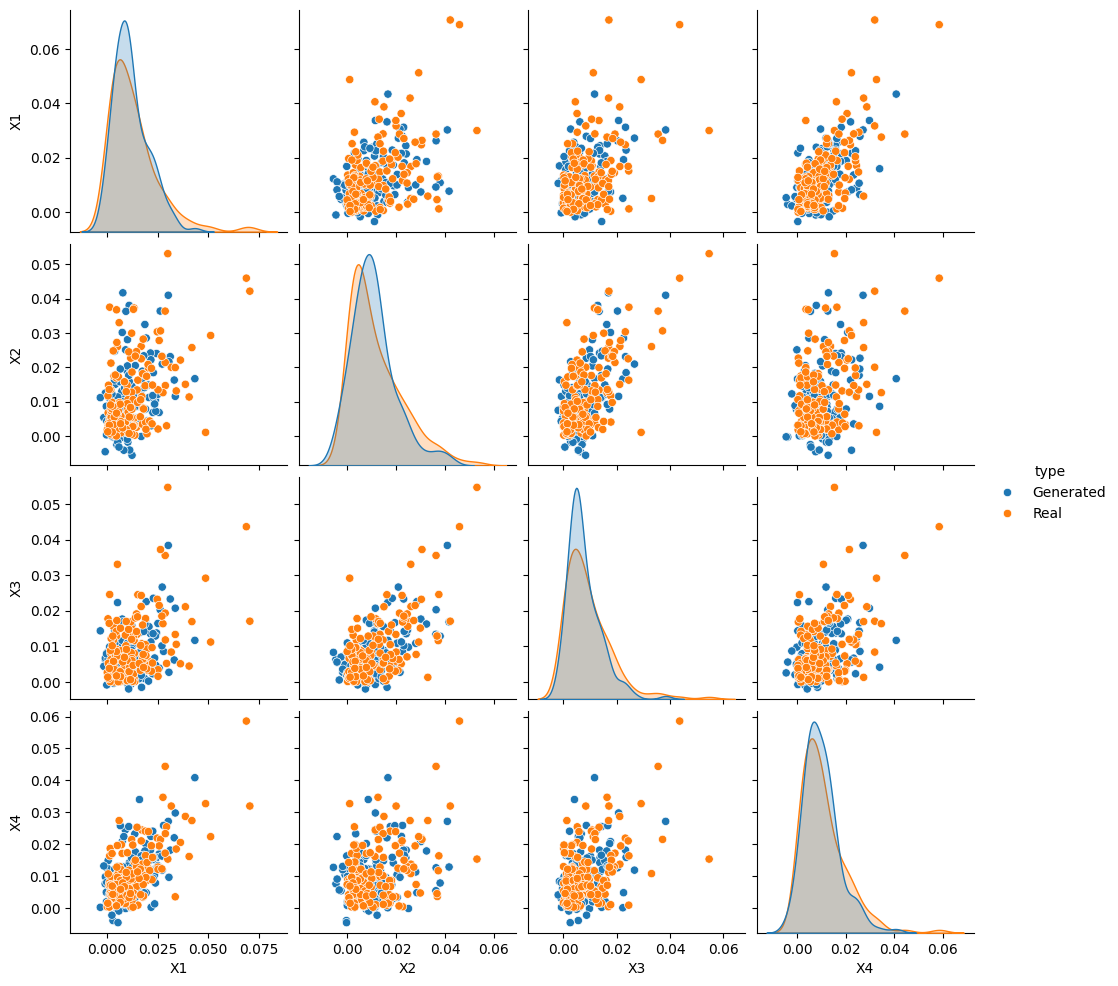

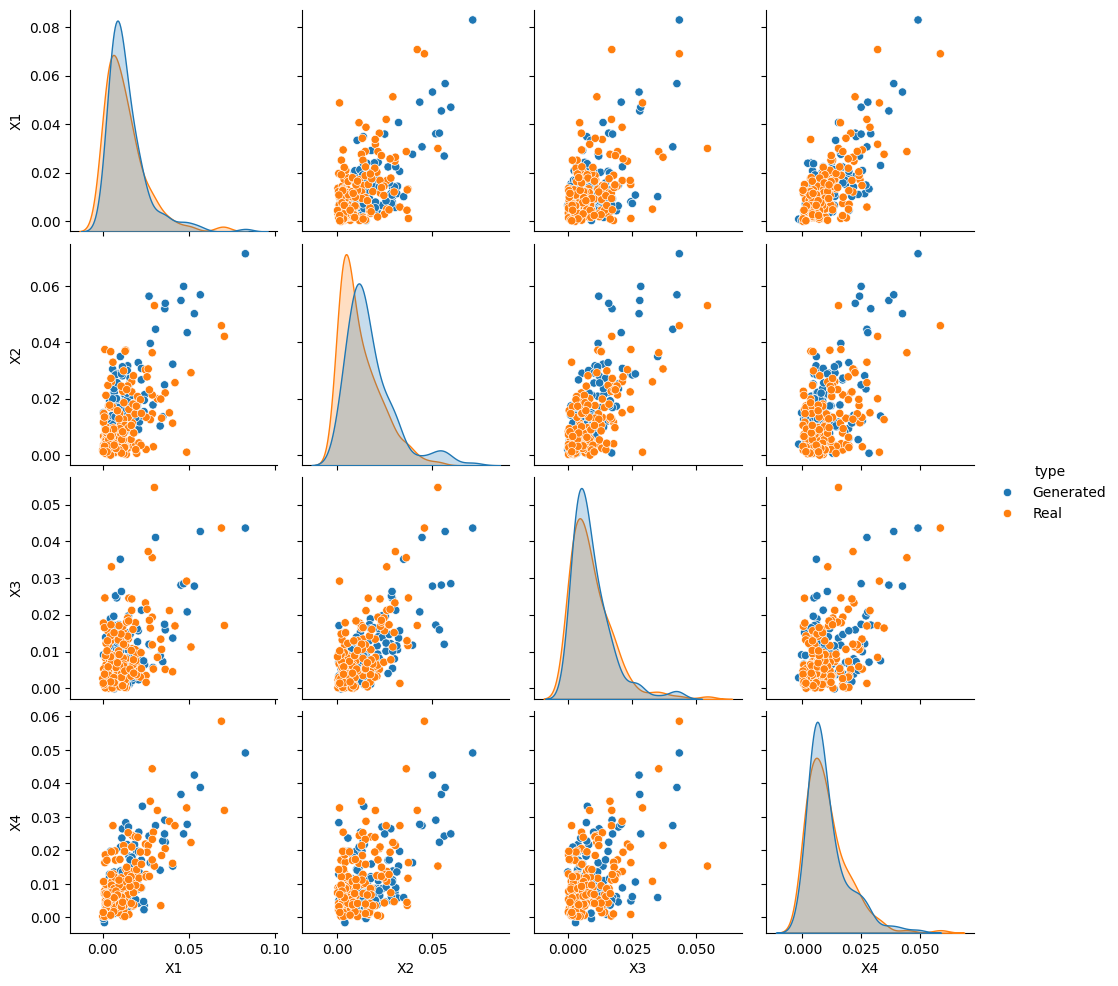

In [ ]:
grid_plot(data_edm, test_data)
grid_plot(data_wgan, test_data)

The following instead display only points for which at least one column displays an "extreme" value (>95% of all others).
This should help us undestand if the models are lacking in estimating extreme values for a particular pair of feature, but the "clouds" do not seem to display unusual behaviours.

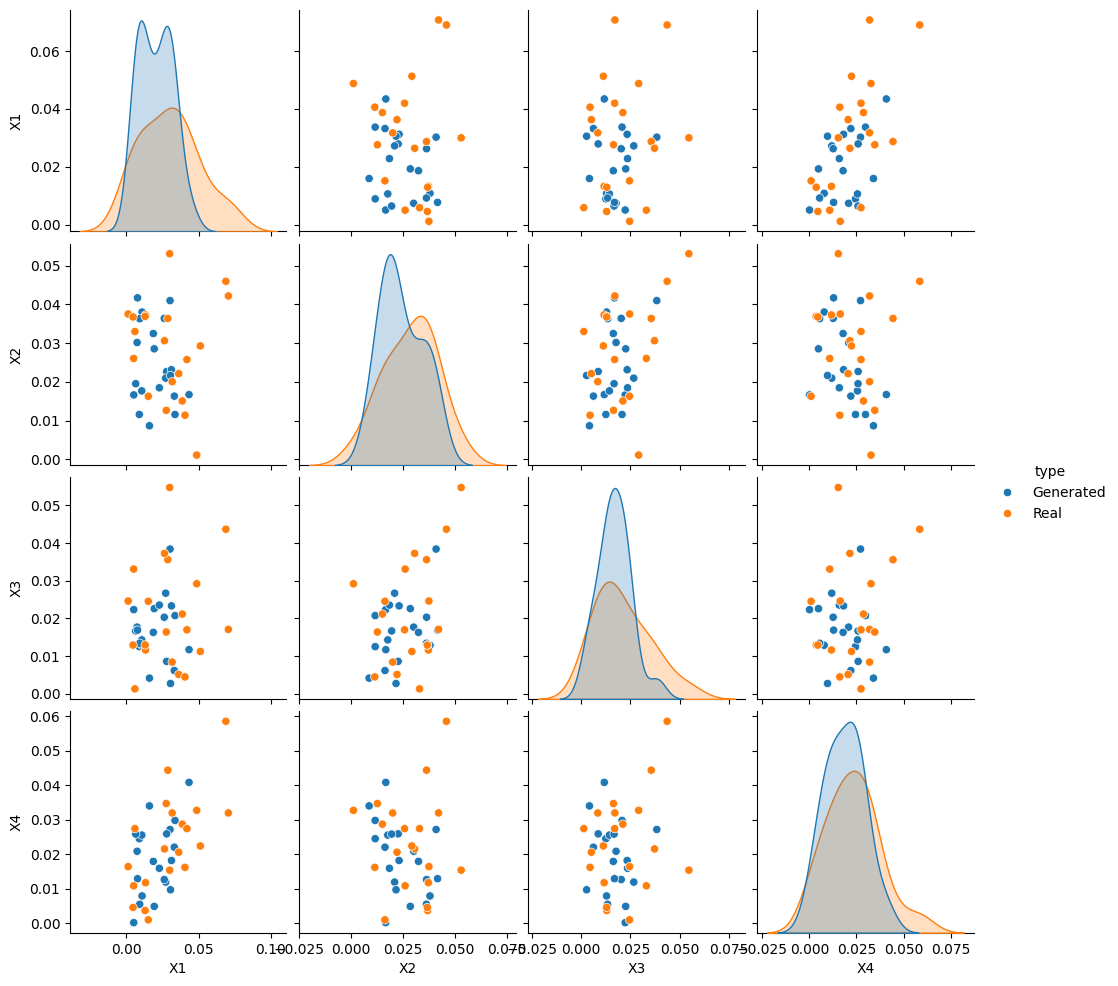

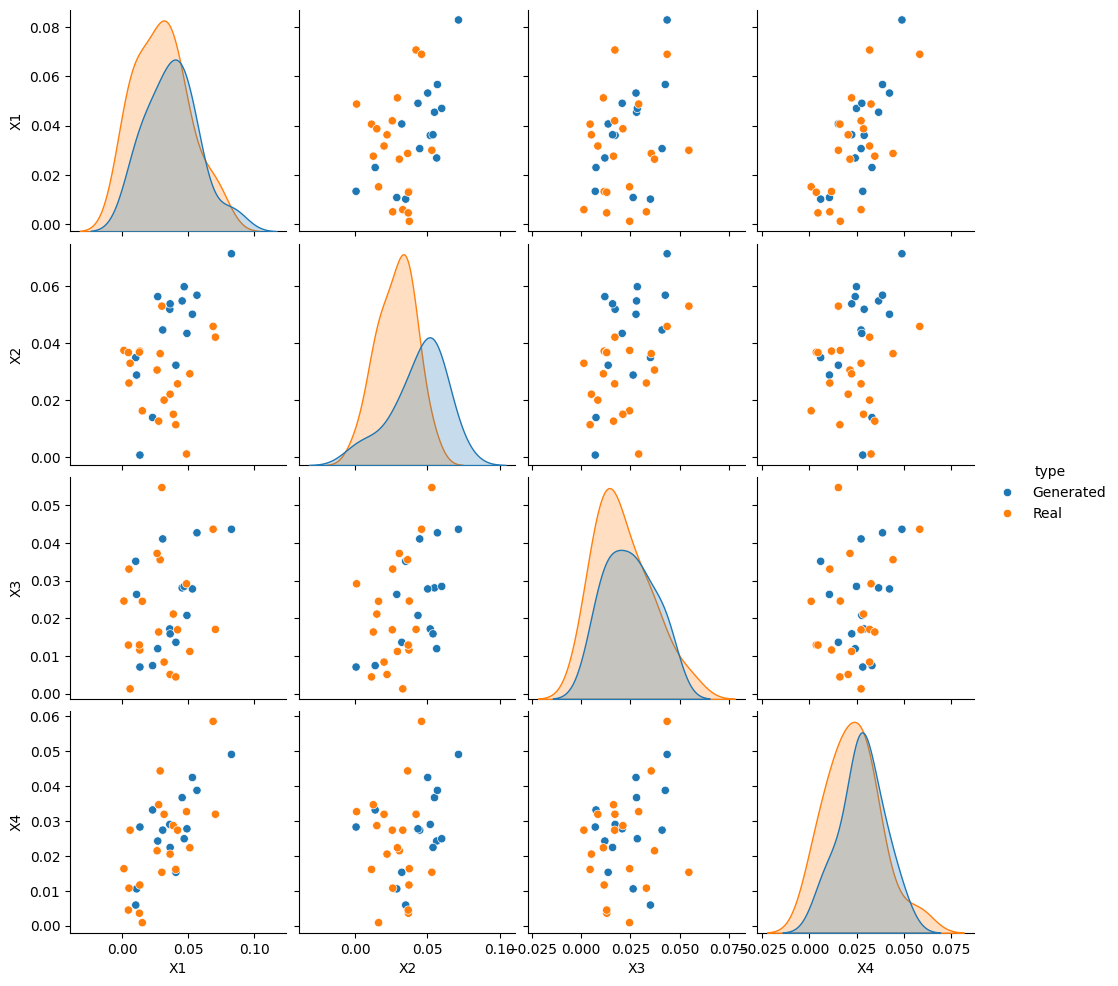

In [ ]:
grid_plot(data_edm, test_data, quantile=0.95)
grid_plot(data_wgan, test_data, quantile=0.95)